# Image Analysis: Non-Stop vs M&M Classification

## Objective
Distinguish between Non-Stop and M&M chocolates using basic image analysis techniques

---

### 1. **Initial Observation**

<img src="images/IMG_2754_nonstop_alltogether.JPG" width="800"/>

<h3 style="marghin-bottom: 0.1em">1.1 Visual Characteristics</h3>

By examining the image we can derive certain characteristic features:
- **M&M's**
    - Elliptical shape
    - More irregular and enlongated shape
    - Slightly smoother texture

- **Non-Stop**
    - Circular shape
    - More uniform shape overall
    - Slightly coarser texture
    - Smoother highlights

- **Chipped pieces**
    - Will be excluded in the identification process with its seperate conditions in this example

## 2. Setup and Imports

In [1]:
from skimage import io, filters, transform, util, measure
from skimage.morphology import disk, opening, remove_small_holes, remove_small_objects, label
from skimage.color import rgb2gray
from skimage.segmentation import watershed
from skimage.filters.rank import entropy
from skimage.feature import peak_local_max
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage as ndi   

# Config
SCALE_FACTOR = 0.2
IMAGE_PATH = "./images/IMG_2754_nonstop_alltogether.JPG"

t_start = time.time()

---

## 3. Pre-processing

### 3.1 Image loading and resizing
The pipeling for preprocessing consists of:
1. **Loading** : Read RGB image
2. **Cropping**: Remove borders to prevent artifacts
3. **Resizing**: Downscaling by a factor of 0.2 to reduce computation time
4. **8bit conversion**: Convert to uint8 (0-255)
5. **Gaussian blur**: Apply slight gaussian blur to remove noise that might affect our binary mask

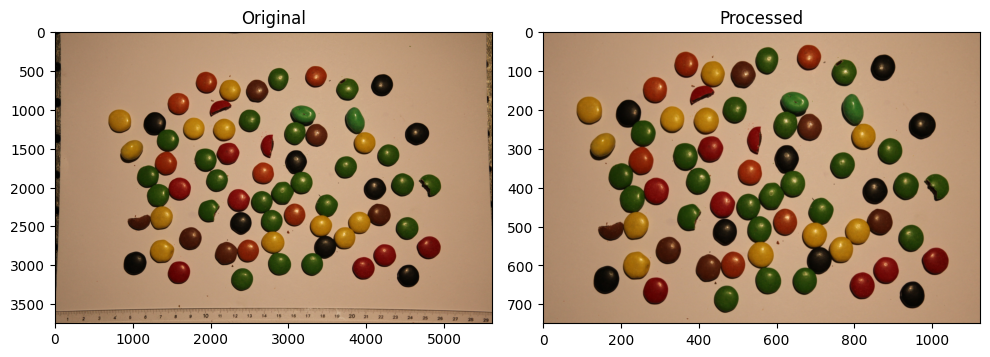

In [2]:
def load_image(filepath: str, scale_factor: float = SCALE_FACTOR) -> np.ndarray:
  """Load an image from disk, crop 300 pixels from all four sides, resize by scale_factor, and return as an 8-bit ndarray.
  Parameters
  ----------
  filepath : str
    Path to the image file.
  scale_factor : float, optional
    Multiplicative factor applied to the original image dimensions (default: SCALE_FACTOR).
  Returns
  -------
  np.ndarray
    Cropped and resized image as an uint8 array with shape (H, W, C).
  Notes
  -----
  - Cropping applied: ((300, 300), (300, 300), (0, 0)).
  - Resizing uses anti-aliasing and preserves the original value range before casting to uint8.
  """
  fig, ax = plt.subplots(1, 2, figsize = (10, 15))

  # Load image
  img = io.imread(filepath)

  # Crop
  image_cropped = util.crop(img, ((300, 300),(300, 300),(0, 0)))

  # Resize
  height = img.shape[0] * scale_factor
  width = img.shape[1] * scale_factor
  img_resized = transform.resize(image_cropped, (height, width), anti_aliasing=True, preserve_range=True)

  # 8-bit conversion
  img_int = img_resized.astype(np.uint8)

  # Plot results
  ax[0].imshow(img)
  ax[1].imshow(img_int)
  ax[0].set_title("Original")
  ax[1].set_title("Processed")
  plt.tight_layout()
  plt.show()

  # Return 8-bit color image
  return img_int

img = load_image(IMAGE_PATH, SCALE_FACTOR)

---

### 3.2 Channel Analysis for Background Separation
By experimenting with channel extraction in different color spaces, we can determine what is best for foreground and background separation.
Looking at the image we can see that there are no blue chocolates. The background however, will have more information in the blue spectrum.

After experimenting with channels in both HSV and LAB color spaces, we still ended up with the best results for separation using the RGB blue channel

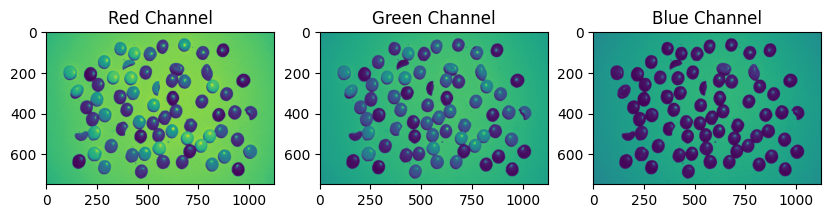

In [3]:
fig, ax = plt.subplots(1, 3, figsize = (10, 15))

ax[0].imshow(img[:, :, 0])
ax[1].imshow(img[:, :, 1])
ax[2].imshow(img[:, :, 2])

ax[0].set_title("Red Channel")
ax[1].set_title("Green Channel")
ax[2].set_title("Blue Channel");

**We can clearly see that the blue channel has a much higher contrast between the foreground and background**, so we will use this channel to create the binary mask

---

### 3.3 Binary Mask Creation

Segmentation pipeline:
1. **Gaussian Blur**: Applied to the blue channel to reduce noise for better thresholding
2. **Otsu Thresholding**: Performed automatic thresholding for binary segmentation 
3. **Morphological Operations**:
    - Remove small holes with a set size threshold
    - Remove small objects with a set size threshold
    - Perform Opening operation with a disk kernel
4. **Inversion**: Invert the mask such that chocolates become foreground

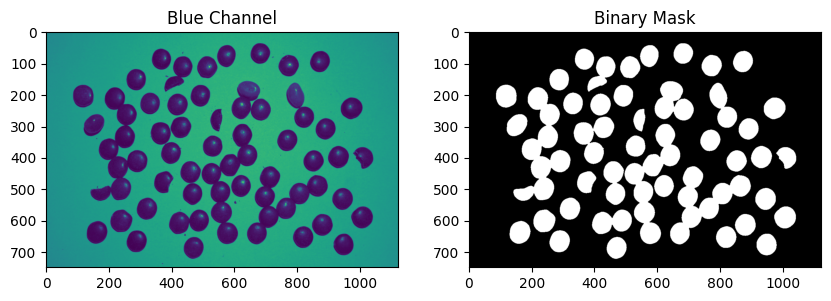

In [4]:
def create_bin_mask(image: np.ndarray, scale_factor: float = SCALE_FACTOR) -> np.ndarray:
  """
  Create a binary mask isolating regions based on the blue channel.
  Args:
      image (np.ndarray): Input RGB image of shape (H, W, 3).
      scale_factor (float, optional): Factor for area thresholds when removing small
          holes or objects. Default is SCALE_FACTOR.
  Returns:
      np.ndarray: Boolean mask of shape (H, W)
  ---
  Notes:
      Requires scikit-image (filters, morphology). Input image should have an
      intensity range compatible with skimage filters (e.g. 0–1 or 0–255).
  """

  # Extract channels
  red_c = image[:, :, 0]
  green_c = image[:, :, 1]
  #blue_c = image[:, :, 2]

  # apply gaussian blur on blue channel to remove small disturbances
  blue_c = filters.gaussian(image[:, :, 2])

  # Create binary mask
  bin_mask = blue_c > filters.threshold_otsu(blue_c, nbins=256)

  # Clean the mask by removing small holes and objects
  # Perform opening to deal with the residual noise
  bin_mask = remove_small_holes(bin_mask, area_threshold=int(700*scale_factor))
  bin_mask = remove_small_objects(bin_mask, min_size=int(700*scale_factor))
  bin_mask = opening(bin_mask, disk(1))
  bin_mask = ~bin_mask

  return bin_mask

binary_mask = create_bin_mask(img, SCALE_FACTOR)

fig, ax = plt.subplots(1, 2, figsize = (10, 15))
ax[0].imshow(img[:, :, 2])
ax[1].imshow(binary_mask, 'gray')
ax[0].set_title("Blue Channel")
ax[1].set_title("Binary Mask");

## 4. Feature Extraction

### 4.1 Watershed Segmentation
To separate touching chocolates, we use **watershed-segmentation** which simulates water flowing from the points derived from the **euclidian distance transform** (converts each foreground pixel to its distance from the nearest background). Where the water meets; we have a boundary

### 4.2 Extracting Region Properties
For each segment, we can extract region properties using skimage built in functionality

**Relevant Features**:
- Solidity
- Eccentricity
- Major Axis Length
- Minor Axis Length
- Perimeter
- Area

**Derived Features**:
- Circularity: 4π × Area / Perimeter² (1 = perfect circle)
- Aspect Ratio: Major axis / Minor axis


In [10]:
def find_regions(image: np.ndarray, binary_mask: np.ndarray) -> pd.DataFrame:
  """Detect and measure separated regions in a binary mask using distance transform + watershed.

  Args:
    image : np.ndarray
      Original image (RGB or grayscale). Not used by default (kept for optional texture/entropy calculations).
    binary_mask : np.ndarray
      Binary mask (bool or {0,1}) of foreground regions to be separated; must match image shape.

  Returns:
      pd.DataFrame: Region properties table
  """  

  #Distance transform
  distance = ndi.distance_transform_edt(binary_mask)

  #Find local maxima
  coords = peak_local_max(distance, min_distance=10, labels=binary_mask)

  #Create markers
  markers = np.zeros(distance.shape, dtype=bool)

  markers[tuple(coords.T)] = True
  markers = label(markers)

  # 4. Watershed
  labels = watershed(-distance, markers, mask=binary_mask)

  # Extract data
  props = measure.regionprops_table(labels, properties=(
    'label',
    'area',
    'perimeter',
    'centroid',
    'eccentricity',
    'solidity',
    'major_axis_length',
    'minor_axis_length',
  ))

  df = pd.DataFrame(props)
  df['circularity'] = (4 * np.pi * df['area']) / (df['perimeter'] ** 2)
  df['aspect_ratio'] = df['major_axis_length'] / df['minor_axis_length']

  return df

data = find_regions(img, binary_mask)

# Display feature statistics
print('Feature Extraction Summary:')
print('=' * 60)
print(f'Total chocolates detected: {len(data)}')
print('\nFeature Statistics:')
data


Feature Extraction Summary:
Total chocolates detected: 68

Feature Statistics:


,label,area,perimeter,centroid-0,centroid-1,eccentricity,solidity,major_axis_length,minor_axis_length,circularity,aspect_ratio
0,1,3188.0,207.823376,67.856023,681.159975,0.369120,0.985471,66.100397,61.432493,0.927554,1.075984
1,2,3219.0,210.651804,75.760174,573.453557,0.561515,0.985006,70.404434,58.257332,0.911592,1.208508
2,3,3225.0,209.823376,86.112248,366.713798,0.415224,0.984733,67.194363,61.127997,0.920517,1.099240
3,4,3349.0,215.480231,93.700806,871.317408,0.446134,0.981824,69.034725,61.783726,0.906380,1.117361
4,5,3395.0,216.894444,106.640353,771.672754,0.402468,0.983203,68.740781,62.927643,0.906886,1.092378
...,...,...,...,...,...,...,...,...,...,...,...
63,64,3658.0,226.066017,640.609349,576.466102,0.303735,0.979122,69.959465,66.654348,0.899462,1.049586
64,65,3482.0,218.894444,653.312751,817.837450,0.373180,0.983616,69.133755,64.139456,0.913207,1.077866
65,66,3571.0,221.480231,666.575749,288.056567,0.442050,0.984832,71.209753,63.874464,0.914808,1.114839
66,67,3476.0,217.480231,676.972382,946.401323,0.381644,0.984982,69.209449,63.970949,0.923528,1.081889


## 5. **Algorithm & Methodology**

### 5.1 Feature Distribution
To determine which features might be relevant, we plot histograms for each. This is a good starting point for finding the correct parameters.
The thresholds shown are our final parameters.

### 5.2 Classification Strategy
We use a **rule-based classicication** for the relevant features extracted previously.
By using our histograms as starting points for our experiment, we ended up with the following rules:

**Chipped Chocolates:**

- **Aspect Ratio** (threshold: 1.3)
    - Ratio of major to minor axis
    - M&Ms have higher ratios due to elongation

- **Solidity** (threshold: 0.97)
    - Ratio of area to convex hull area
    - Lower solidity indicates chipped/damaged chocolates

**M&M's:**

- **Eccentricity** (Threshold: 0.55)
    - M&Ms are more elliptical (higher eccentricity)
    - Non-Stops are more circular (lower eccentricity)

- **Circularity** (threshold: 0.9)
    - Perfect circle = 1.0
    - M&Ms deviate more from circular (< 0.9)
    - Non-Stops maintain higher circularity (> 0.9)
- **Exclude chipped pieces**


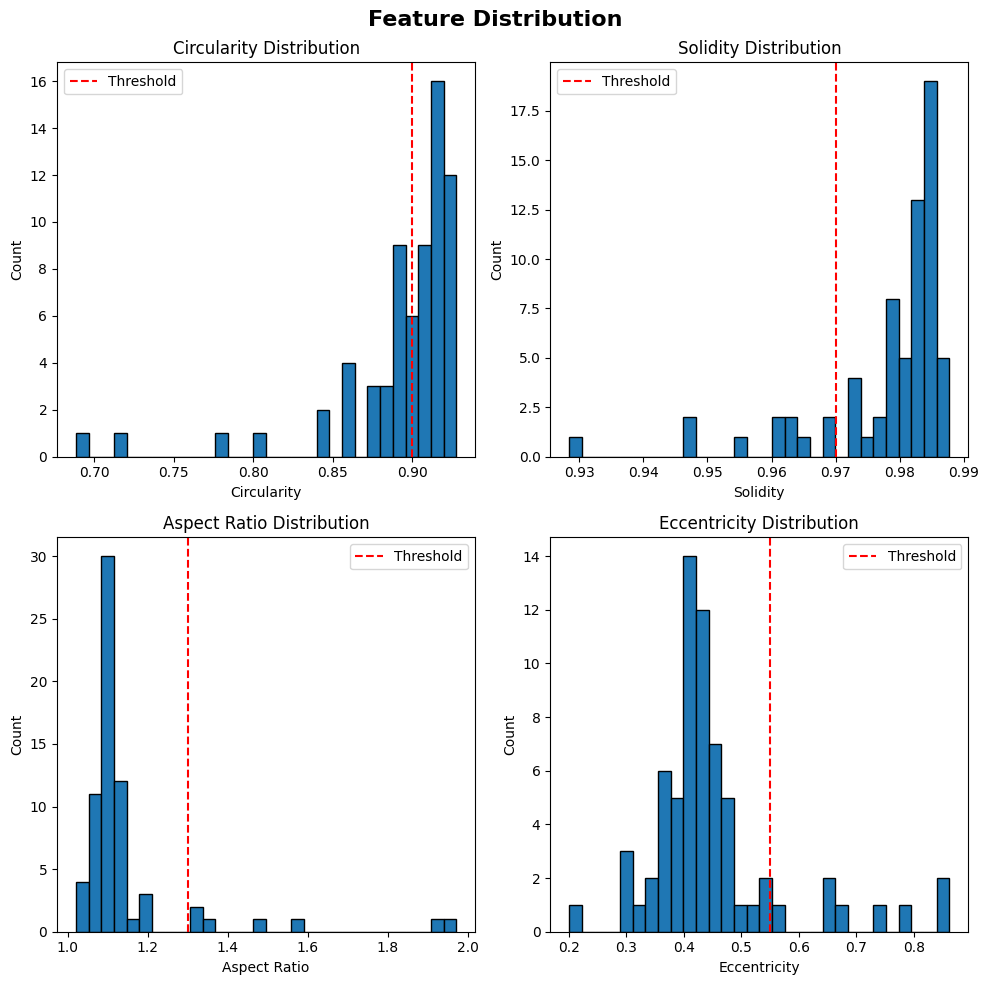

In [21]:
def plot_measurements(data:pd.DataFrame):
  """
  Plots a 2x2 grid of histograms showing the distribution of object features.
  The function creates histograms for circularity, solidity, aspect ratio, and eccentricity
  measurements, with threshold lines indicating classification boundaries.

  Args:
    data (pd.DataFrame): DataFrame containing feature measurements.

  Returns:
    None
  """

  fig, ax = plt.subplots(2, 2, figsize=(10, 10))
  fig.suptitle('Feature Distribution', fontsize=16, fontweight='bold')
  

  plots = [
    ('circularity', 'Circularity', 0.9),
    ('solidity', "Solidity", 0.97),
    ('aspect_ratio', 'Aspect Ratio', 1.3),
    ('eccentricity', 'Eccentricity', 0.55),
  ]

  
  for axes, (col, title, threshold) in zip(ax.flat, plots):
    axes.hist(data[col], bins=30, edgecolor='black')
    axes.set_xlabel(title)
    axes.set_ylabel('Count')
    axes.set_title(f"{title} Distribution")
    axes.axvline(threshold, color='r', linestyle='--', label='Threshold')
    axes.legend()


  plt.tight_layout()
  plt.show()

plot_measurements(data)

## 6. Results & Analysis
Implementing our rules we get the following result

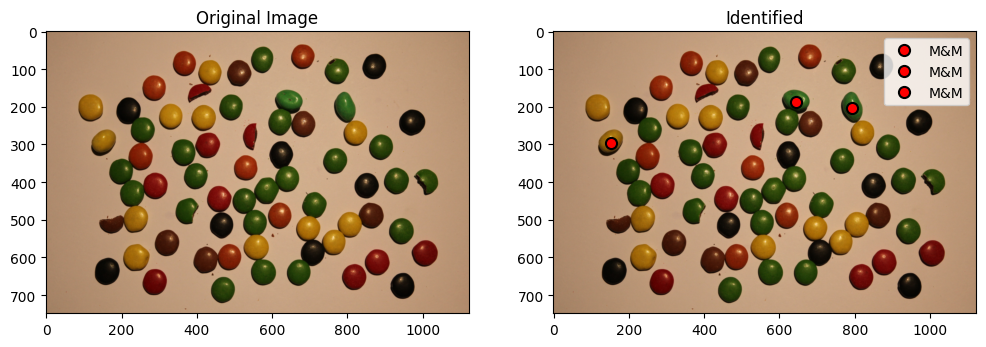

In [15]:
def identify_mm(img:np.ndarray, data:pd.DataFrame) -> None:
  """
  Identifies M&M's and chipped chocolates in an image based on specified parameters.
  Parameters:
    img (np.ndarray): The input image containing potential M&M's.
    data (pd.DataFrame): A DataFrame containing features of detected objects, including 
               aspect ratio, solidity, eccentricity, circularity, and centroids.
  Returns:
    None: The function plots the original image and highlights identified M&M's.
  """
  # Identification parameteres
  ASPECT_RATIO = 1.3
  SOLIDITY = 0.97
  ECCENTRICITY = 0.55
  CIRCULARITY = 0.9

  # Detect chipped chocolates
  data['is_chipped'] = (
    (data['aspect_ratio'] > ASPECT_RATIO) & 
    (data['solidity'] < SOLIDITY))

  # Detect M&M's
  data['is_mm'] = (
    (data["eccentricity"] > ECCENTRICITY) &
    (data["circularity"] < CIRCULARITY) &
    (~data["is_chipped"]))

  # Plot result
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  ax[0].imshow(img)
  ax[0].set_title('Original Image')
  ax[1].set_title('Identified')
  
  ax[1].imshow(img)
  for idx, row in data.iterrows():
    if row["is_mm"]:
        y, x = row['centroid-0'], row['centroid-1']
        ax[1].plot(x, y, 'ro', markersize=8, markeredgecolor='black', markeredgewidth=1.5, label="M&M")
        
  ax[1].legend()
  plt.show()
  
identify_mm(img, data)

### 6.1 Analysis
- Clear separation between M&Ms and Non-Stops in feature space
- Chipped chocolates occupy distinct region (high aspect ratio, low solidity)


### 6.2 Challenges
1. **Touching Chocolates**: Some chocolates touch or overlap, making segmentation difficult
   - *Solution*: Watershed algorithm with distance transform-based markers
   - *Result*: Most touching chocolates successfully separated

2. **Chipped/Damaged Chocolates**: Physical damage alters shape features
   - *Solution*: Additional classification category using solidity metric
   - *Result*: Successfully identified as separate class

3. **Color Variations**: Both chocolate types come in multiple colors
   - *Solution*: Shape-based classification instead of color-based
   - *Result*: Robust to color variations

4. **Lighting and Shadow**: Non-uniform illumination affects segmentation
   - *Solution*: Gaussian smoothing and Otsu's adaptive thresholding
   - *Result*: Minimal impact on final classification

### 6.3 Limitations
1. **Threshold Dependency**: Classification thresholds are manually tuned for this specific dataset
2. **Edge Cases**: Severely damaged chocolates may be misclassified
3. **Scalability**: Thresholds may need adjustment for different imaging conditions
4. **Texture Feature**: Entropy-based texture analysis not fully utilized in final classification



### 7. Conclusion
This analysis successfully distinguished between M&M and Non-Stop chocolates using geometric shape features extracted through image processing and morphological operations.

**Key Results**:
- **Accuracy**: High classification accuracy based on visual inspection
- **Primary Features**: Eccentricity and circularity proved most discriminative
- **Robust Approach**: Shape-based classification independent of color variations
- **Damage Detection**: Successfully identified and excluded damaged chocolates

**Methodology Strengths**:
- Interpretable rule-based classification
- Well-established image processing techniques (watershed, morphology)
- Minimal preprocessing required
- Robust to lighting variations

**Future Improvements:**
1. **Enhanced Texture Analysis**:
   - Incorporate entropy-based texture features into classification

2. **Edge Detection for Enhanced Segmentation**:
   - **Sobel Filter Application**: Apply Sobel edge detection to identify chocolate boundaries more precisely
     - Sobel provides gradient magnitude and direction information
     - Could combine horizontal and vertical Sobel operators to detect edges at all orientations
     - May help distinguish between smooth circular Non-Stops and slightly irregular M&M edges
   
   - **Canny Edge Detection**: Use Canny algorithm for more refined boundary detection
     - Multi-stage algorithm (Gaussian smoothing → gradient calculation → non-maximum suppression → hysteresis thresholding)
     - Produces thin, connected edges which could improve perimeter measurements
     - Could use edge continuity as a feature: chipped chocolates would have broken edge contours
3. **Improved Watershed Segmentation**:
   - Use gradient-based watershed instead of distance transform
   - Apply Sobel filter to find object boundaries, then use these gradients for watershed
   - Could provide better separation for chocolates with weak boundaries in distance transform
   - Edge-based markers might improve segmentation of irregularly shaped chocolates

